<div style="text-align:right">Update date: Feb 18, 2024</div><br>

# Lead Scoring<br>
## Objetive<br><br>
Prepare visitor data for a commercial landing page, with the purpose of generating a solution that improves the conversion rate of sales leads through predictive customer segmentation and lead scoring models, allowing salespeople to focus on potential customers. that contribute to obtaining more income for the business.<br><br>

## The general outline of this notebook is as follows:

    1. Imports and adjustments
    2. Load data
    3. Reserve the validation dataset
    4. Data quality
    6. Transform variables
    7. Preselect variables
    8. Save training dataset
    
    
<br>

## Main work tools<br>


|Package|                           Version|
|:---------------------------------|--------:|
|cloudpickle                       |3.0.0|
|numpy                             | 1.26.3|
|notebook                          |6.5.4|
|pandas                            | 2.1.4|
|python                            |3.11.7|
|sklearn                           |1.2.2|
|xgboost                           |1.7.3|

## Imports and adjustments

In [2]:
import os
import pandas as pd
import numpy as np
import cloudpickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance



#Autocompletar
%config IPCompleter.greedy = True

## Load data

In [4]:
df = pd.read_csv('data/Leads.csv', sep=';',index_col='id')
df

,origen,fuente,no_enviar_email,no_llamar,compra,visitas_total,tiempo_en_site_total,paginas_vistas_visita,ult_actividad,ambito,ocupacion,conociste_google,conociste_revista,conociste_periodico,conociste_youtube,conociste_facebook,conociste_referencias,score_actividad,score_perfil,descarga_lm
id,,,,,,,,,,,,,,,,,,,,
660737,API,Chat,No,No,0,0.0,0,0.00,Page Visited on Website,Select,Unemployed,No,No,No,No,No,No,15.0,15.0,No
660728,API,Organic Search,No,No,0,5.0,674,2.50,Email Opened,Select,Unemployed,No,No,No,No,No,No,15.0,15.0,No
660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.00,Email Opened,Business Administration,Student,No,No,No,No,No,No,14.0,20.0,Yes
660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.00,Unreachable,Media and Advertising,Unemployed,No,No,No,No,No,No,13.0,17.0,No
660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.00,Converted to Lead,Select,Unemployed,No,No,No,No,No,No,15.0,18.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579564,Landing Page Submission,Direct Traffic,Yes,No,1,8.0,1845,2.67,Email Marked Spam,IT Projects Management,Unemployed,No,No,No,No,No,No,15.0,17.0,No
579546,Landing Page Submission,Direct Traffic,No,No,0,2.0,238,2.00,SMS Sent,Media and Advertising,Unemployed,No,No,No,No,No,No,14.0,19.0,Yes
579545,Landing Page Submission,Direct Traffic,Yes,No,0,2.0,199,2.00,SMS Sent,Business Administration,Unemployed,No,No,No,No,No,No,13.0,20.0,Yes


## Reserve the validation dataset

In [3]:
val = df.sample(frac=0.3)
val.to_csv('data/validation.csv')

## Data quality

In [4]:
work = df[~df.index.isin(val.index)]
work.shape

(6365, 20)

Discard leads who do not want to be sent an email, observations corresponding to the latest activities carried out on the landing page through a temporary email, and leads who do not want to receive calls.

In [5]:
work = work.drop_duplicates()
condition = ((work['no_enviar_email'] != 'Yes')
             & (work['no_llamar'] != 'Yes')
             & (work['ult_actividad'] != 'Email Bounced')
            )
work = work[condition]
work.shape

(4813, 20)

Generate helper functions for:
* Impute null values in numerical and categorical variables
* Update outliers

In [6]:
# Update values in variables:
var_imputar_valor = [
    'origen',
    'fuente',
    'no_enviar_email',
    'no_llamar',
    'ult_actividad',
    'conociste_google',
    'conociste_revista',
    'conociste_facebook',
    'conociste_referencias',
    'descarga_lm'
]
var_imputar_moda = ['ocupacion', 'ambito']
# Define helper functions
def imputar_moda(variable):
    return variable.fillna(variable.mode()[0])

def imputar_mediana(variable):
    if pd.api.types.is_integer_dtype(variable):
        return variable.fillna(int(variable.median()))
    
    return variable.fillna(variable.median())

def agrupar_cat_raras(variable, criterio=0.05):
    frecuencias = variable.value_counts(normalize=True)
    temp = list(frecuencias.loc[frecuencias < criterio].index.values)
    temp2 = np.where(variable.isin(temp), 'OTROS', variable)
    
    return temp2

def calidad_datos(df):
    temp = df.astype({'visitas_total': 'Int64'})             
    temp[var_imputar_moda] = temp[var_imputar_moda].apply(imputar_moda)
    temp[var_imputar_valor] = temp[var_imputar_valor].fillna('DESCONOCIDO')
    var_imputar_mediana = temp.select_dtypes(include='number').columns.to_list()
    temp[var_imputar_mediana] = temp[var_imputar_mediana].apply(imputar_mediana)
    var_poco_frecuentes = temp.select_dtypes(exclude='number').columns.to_list()   
    for variable in var_poco_frecuentes:
        temp[variable] = agrupar_cat_raras(temp[variable], criterio=0.02)
    temp['visitas_total'] = temp['visitas_total'].clip(0, 50)
    temp['paginas_vistas_visita'] = temp['paginas_vistas_visita'].clip(0, 20)
    
    return(temp)

In [7]:
work = calidad_datos(work)

In [8]:
work.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4813 entries, 660737 to 579538
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   origen                 4813 non-null   object 
 1   fuente                 4813 non-null   object 
 2   no_enviar_email        4813 non-null   object 
 3   no_llamar              4813 non-null   object 
 4   compra                 4813 non-null   int64  
 5   visitas_total          4813 non-null   Int64  
 6   tiempo_en_site_total   4813 non-null   int64  
 7   paginas_vistas_visita  4813 non-null   float64
 8   ult_actividad          4813 non-null   object 
 9   ambito                 4813 non-null   object 
 10  ocupacion              4813 non-null   object 
 11  conociste_google       4813 non-null   object 
 12  conociste_revista      4813 non-null   object 
 13  conociste_periodico    4813 non-null   object 
 14  conociste_youtube      4813 non-null   object 
 15  co

## Transform variables

Separate numerical and categorical variables

In [9]:
num = work.select_dtypes(include='number').copy()
cat = work.select_dtypes(exclude='number').copy()

In [10]:
num.shape, cat.shape

((4813, 6), (4813, 14))

### Categorical variables

#### One Hot Encoding

In [11]:
var_ohe = ['origen', 'fuente', 'ult_actividad', 'ambito', 'ocupacion', 'descarga_lm']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_ohe = ohe.fit_transform(cat[var_ohe])
cat_ohe = pd.DataFrame(cat_ohe, columns=ohe.get_feature_names_out())

### Numerical variables

In [12]:
work = pd.concat([cat_ohe, num.reset_index()], axis=1)
work

,origen_API,origen_Landing Page Submission,origen_Lead Add Form,origen_OTROS,fuente_Chat,fuente_Direct Traffic,fuente_Google,fuente_OTROS,fuente_Organic Search,fuente_Reference,...,ocupacion_Working Professional,descarga_lm_No,descarga_lm_Yes,id,compra,visitas_total,tiempo_en_site_total,paginas_vistas_visita,score_actividad,score_perfil
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,660737,0,0,0,0.0,15.0,15.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,660719,0,1,305,1.0,13.0,17.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,660681,1,2,1428,1.0,15.0,18.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,660616,0,4,58,4.0,13.0,16.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,660608,1,8,1351,8.0,15.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,579697,1,8,1016,4.0,15.0,20.0
4809,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,579642,0,2,1770,2.0,14.0,20.0
4810,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,579622,1,13,1409,2.6,14.0,16.0
4811,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,579546,0,2,238,2.0,14.0,19.0


#### Rescale variables with Min-Max

In [13]:
work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4813 entries, 0 to 4812
Data columns (total 44 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   origen_API                                4813 non-null   float64
 1   origen_Landing Page Submission            4813 non-null   float64
 2   origen_Lead Add Form                      4813 non-null   float64
 3   origen_OTROS                              4813 non-null   float64
 4   fuente_Chat                               4813 non-null   float64
 5   fuente_Direct Traffic                     4813 non-null   float64
 6   fuente_Google                             4813 non-null   float64
 7   fuente_OTROS                              4813 non-null   float64
 8   fuente_Organic Search                     4813 non-null   float64
 9   fuente_Reference                          4813 non-null   float64
 10  ult_actividad_Chat Conversation     

In [14]:
var_mms = work.iloc[:, 39:].columns
mms = MinMaxScaler()
df_mms = mms.fit_transform(work[var_mms])
nombres_mms = [variable + '_mms' for variable in var_mms]
df_mms = pd.DataFrame(df_mms, columns=nombres_mms)

#### Unify rescaled datasets

In [15]:
incluir = [work.compra, cat_ohe, df_mms, work.id]

In [16]:
df_datamart = pd.concat(incluir, axis=1).set_index('id')

In [17]:
df_datamart.to_pickle('data/df_datamart.pickle')

## Preselect variables

In [18]:
df = pd.read_pickle('data/df_datamart.pickle')

Separate predictors and targets

In [19]:
target = 'compra'
x = df.drop(columns=target).copy()
y =  df[target].copy()

#### Permutation Importance

In [20]:
def ranking_per(predictoras, permutacion):
    dict_pred = {
        'variable': predictoras.columns,
        'importancia_per': permutacion.importances_mean
    }
    ranking_per = pd.DataFrame(dict_pred)\
            .sort_values(by='importancia_per', ascending=False)            
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    
    return(ranking_per)

Instantiate and train

In [21]:
xgb = XGBClassifier(n_jobs=-1, eval_metric='auc')
xgb.fit(x, y)
permutacion = permutation_importance(estimator=xgb, 
                                     X=x,
                                     y=y, 
                                     scoring='roc_auc',
                                     n_repeats=5,
                                     n_jobs=-1
                                    )

Check the output

<Axes: ylabel='variable'>

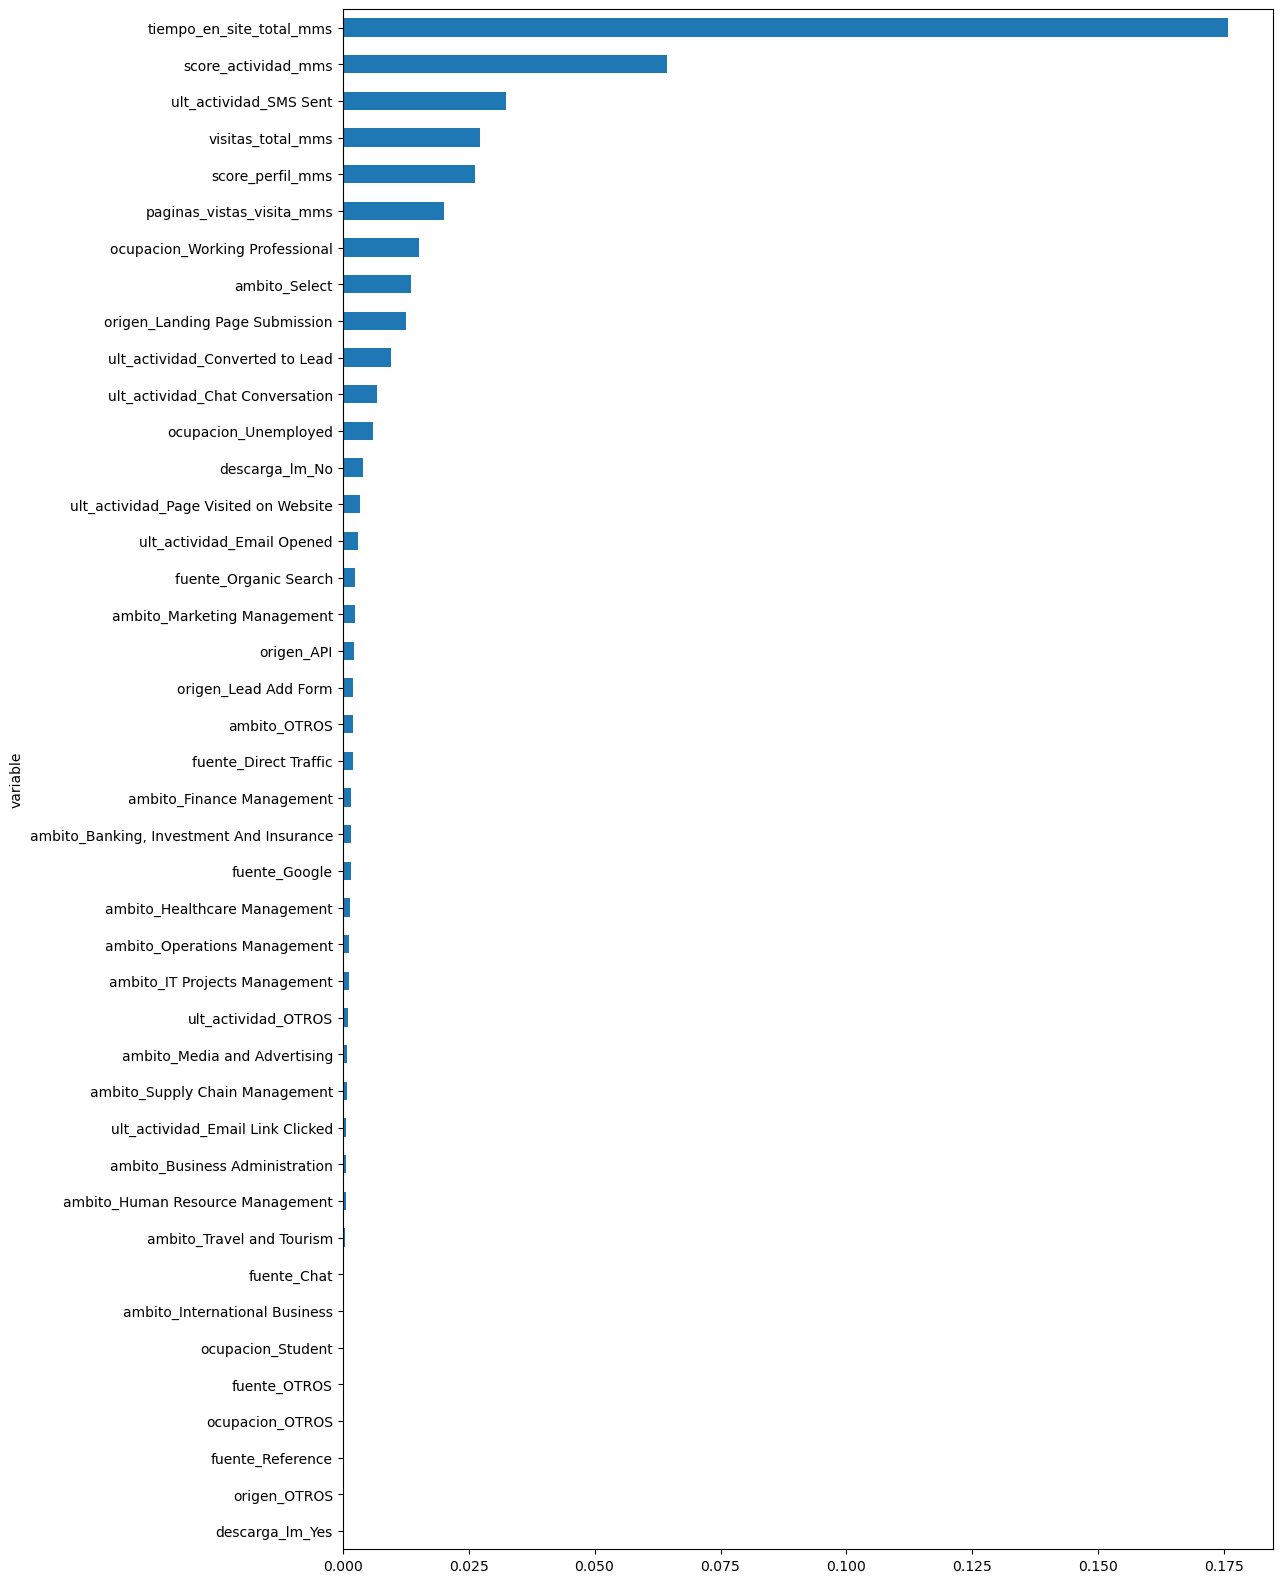

In [22]:
rank_per = ranking_per(x, permutacion)
(rank_per.set_index('variable').importancia_per.sort_values()
 .plot.barh(figsize=(12,20))
)

Select variables

In [23]:
var_per = x[rank_per.iloc[0:21].variable].copy()

#### Check correlation of variables

In [24]:
def strong_correlations(df, lower_limit=0.3, upper_limit=1, drop_duplicates=True):
    """Finds strong correlations between variables in a DataFrame.
    """

    # Compute correlation matrix and get absolute values
    c = df.corr().abs()
    
    # Stack correlation matrix and reset index
    c = c.unstack().reset_index()
    c.columns = ['var1', 'var2', 'corr']
    
    # Filter correlations within the specified limits
    c = c[(c['corr'] > lower_limit) & (c['corr'] < upper_limit)]
    
    # Sort correlations by correlation strength
    c.sort_values(by='corr', ascending=False, inplace=True)
    
    # Drop duplicate correlations if required
    if drop_duplicates:
        c.drop_duplicates(subset=['corr'], inplace=True)
    
    return c

In [25]:
final_corr = strong_correlations(var_per)

In [26]:
final_corr.var1.value_counts()

var1
origen_API                        5
ambito_Select                     4
origen_Landing Page Submission    3
ocupacion_Unemployed              1
descarga_lm_No                    1
paginas_vistas_visita_mms         1
ult_actividad_Email Opened        1
fuente_Direct Traffic             1
origen_Lead Add Form              1
Name: count, dtype: int64

In [27]:
final_corr

,var1,var2,corr
365,origen_API,origen_Landing Page Submission,0.880320
237,ocupacion_Unemployed,ocupacion_Working Professional,0.857854
364,origen_API,ambito_Select,0.716685
155,ambito_Select,origen_Landing Page Submission,0.697961
272,descarga_lm_No,fuente_Direct Traffic,0.584437
108,paginas_vistas_visita_mms,visitas_total_mms,0.569301
296,ult_actividad_Email Opened,ult_actividad_SMS Sent,0.560471
180,origen_Landing Page Submission,descarga_lm_No,0.503243
428,fuente_Direct Traffic,origen_Landing Page Submission,0.458073
159,ambito_Select,descarga_lm_No,0.438690


Reduce the number of highly correlated variables

In [28]:
high_correlation = [
    'origen_API',
    'origen_Landing Page Submission',
    'fuente_Direct Traffic',
    'paginas_vistas_visita_mms',
    'ult_actividad_Email Opened']

var_per.drop(columns=high_correlation, inplace=True)
var_per.columns.to_list()

['tiempo_en_site_total_mms',
 'score_actividad_mms',
 'ult_actividad_SMS Sent',
 'visitas_total_mms',
 'score_perfil_mms',
 'ocupacion_Working Professional',
 'ambito_Select',
 'ult_actividad_Converted to Lead',
 'ult_actividad_Chat Conversation',
 'ocupacion_Unemployed',
 'descarga_lm_No',
 'ult_actividad_Page Visited on Website',
 'fuente_Organic Search',
 'ambito_Marketing Management',
 'origen_Lead Add Form',
 'ambito_OTROS']

## Save training dataset

Save dataset of selected predictor variables and target

In [29]:
var_per.to_pickle('data/x_selected_vars.pickle')
y.to_pickle('data/y_selected_var.pickle')

Save final variables

In [30]:
var_per.iloc[0].to_pickle('data/final_vars.pickle')